In [2]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
# plt.style.use('ggplot')
# % matplotlib inline

In [3]:
df = pd.read_csv('CrisisLexT26/2013_Boston_bombings/2013_Boston_bombings-tweets_labeled.csv') # change the file location if needed

col_dict = {}
for old_feature in df.columns.values:
    col_dict.update({old_feature: old_feature.replace(' ','')})
df.rename(columns=col_dict, inplace=True)

df.Informativeness.value_counts()

Related - but not informative    512
Related and informative          417
Not applicable                    52
Not related                       19
Name: Informativeness, dtype: int64

In [4]:
df = df[df.InformationSource != 'Government']
df = df[df.Informativeness!='Not applicable'].reset_index(drop=True)
df.Informativeness.value_counts()

Related - but not informative    509
Related and informative          392
Not related                       19
Name: Informativeness, dtype: int64

In [5]:
label = ['Not related or not informative'] * df.shape[0]
idx = df.index[df.Informativeness == 'Related and informative'].tolist()
for i in idx: label[i] = 'Related and informative'
df['label'] = pd.Series(label)

df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label
0,323808103780990976,RT @VitoCaro7: Good luck to @kyle_piersma toda...,Not labeled,Not labeled,Not related,Not related or not informative
1,323873597825355778,RT @DianneG: wow. RT @AntDeRosa Photo captures...,Outsiders,Other Useful Information,Related and informative,Related and informative
2,323874466063085568,Awful scenes at the #BostonMarathon. The photo...,Not applicable,Other Useful Information,Related - but not informative,Not related or not informative
3,323874558325161984,Holy shit RT @theoriginalwak: What the fuck ju...,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative
4,323875384603058176,RT @russian_market: BOMB EXPLOSION IN BOSTON (...,Media,Other Useful Information,Related and informative,Related and informative


In [6]:
split_percentage = 0.25
X_train, X_test, y_train, y_test = train_test_split(df.TweetText, df.label, test_size=split_percentage, random_state=42) 
tfidf_vec = TfidfVectorizer(analyzer='word')
X_tfidf_train = tfidf_vec.fit_transform(X_train)  
X_tfidf_test = tfidf_vec.transform(X_test)

In [7]:
mnb_tfidf = MultinomialNB(1)  
mnb_tfidf.fit(X_tfidf_train, y_train)

from sklearn.cross_validation import cross_val_score, KFold 
from scipy.stats import sem 

def evaluate_cross_validation(clf, X, y, K):
    cv = KFold(len(y), K, shuffle=True, random_state=0)  
    scores = cross_val_score(clf, X, y, cv=cv) 
    print scores
    print ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))

evaluate_cross_validation(mnb_tfidf, X_tfidf_train, y_train, 10)

print 'Accuracy for training: {}'.format(mnb_tfidf.score(X_tfidf_train, y_train))
print 'Accuracy for testing: {}'.format(mnb_tfidf.score(X_tfidf_test, y_test))

[0.73913043 0.8115942  0.82608696 0.84057971 0.76811594 0.86956522
 0.76811594 0.8115942  0.8115942  0.82608696]
Mean score: 0.807 (+/-0.012)
Accuracy for training: 0.944927536232
Accuracy for testing: 0.84347826087


D:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
y_tfidf_predict = mnb_tfidf.predict(X_tfidf_test) 
print "Classification Report:" 
print metrics.classification_report(y_test,y_tfidf_predict, digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test,y_tfidf_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.8239    0.9424    0.8792       139
       Related and informative     0.8873    0.6923    0.7778        91

                   avg / total     0.8490    0.8435    0.8391       230

Confusion Matrix:
[[131   8]
 [ 28  63]]


### Add stop words

In [9]:
tfidf_sw_vec = TfidfVectorizer(analyzer='word',stop_words = 'english')
X_tfidf_sw_train = tfidf_sw_vec.fit_transform(X_train)  
X_tfidf_sw_test = tfidf_sw_vec.transform(X_test)

In [10]:
mnb_tfidf_sw = MultinomialNB(0.9)  
mnb_tfidf_sw.fit(X_tfidf_sw_train, y_train)

evaluate_cross_validation(mnb_tfidf_sw, X_tfidf_sw_train, y_train, 10)

print 'Accuracy for training: {}'.format(mnb_tfidf_sw.score(X_tfidf_sw_train, y_train))
print 'Accuracy for testing: {}'.format(mnb_tfidf_sw.score(X_tfidf_sw_test, y_test))

[0.75362319 0.8115942  0.76811594 0.79710145 0.8115942  0.86956522
 0.7826087  0.79710145 0.79710145 0.7826087 ]
Mean score: 0.797 (+/-0.010)
Accuracy for training: 0.963768115942
Accuracy for testing: 0.839130434783


In [11]:
y_tfidf_sw_predict = mnb_tfidf_sw.predict(X_tfidf_sw_test) 
print "Classification Report:" 
print metrics.classification_report(y_test,y_tfidf_sw_predict,digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test,y_tfidf_sw_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.8446    0.8993    0.8711       139
       Related and informative     0.8293    0.7473    0.7861        91

                   avg / total     0.8385    0.8391    0.8375       230

Confusion Matrix:
[[125  14]
 [ 23  68]]


### Token pattern

In [12]:
tfidf_tp_vec = TfidfVectorizer(analyzer='word',stop_words = 'english',token_pattern=ur"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b")
X_tfidf_tp_train = tfidf_tp_vec.fit_transform(X_train)  
X_tfidf_tp_test = tfidf_tp_vec.transform(X_test)

In [13]:
mnb_tfidf_tp = MultinomialNB(2.8)  
mnb_tfidf_tp.fit(X_tfidf_tp_train, y_train)

evaluate_cross_validation(mnb_tfidf_tp, X_tfidf_tp_train, y_train, 10)

print 'Accuracy for training: {}'.format(mnb_tfidf_tp.score(X_tfidf_tp_train, y_train))
print 'Accuracy for testing: {}'.format(mnb_tfidf_tp.score(X_tfidf_tp_test, y_test))

[0.66666667 0.8115942  0.82608696 0.76811594 0.85507246 0.84057971
 0.73913043 0.73913043 0.76811594 0.76811594]
Mean score: 0.778 (+/-0.018)
Accuracy for training: 0.93768115942
Accuracy for testing: 0.839130434783


### Pre-process

In [14]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import HashingVectorizer
import preprocessor as p

emoji_re = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF']"
emojis = [regexp_tokenize(t, emoji_re) for t in df.TweetText]
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i] if t not in en_stop ]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,323808103780990976,RT @VitoCaro7: Good luck to @kyle_piersma toda...,Not labeled,Not labeled,Not related,Not related or not informative,rt @vitocaro7 : good luck @kyle_piersma today ...
1,323873597825355778,RT @DianneG: wow. RT @AntDeRosa Photo captures...,Outsiders,Other Useful Information,Related and informative,Related and informative,rt @dianneg : wow . rt @antderosa photo captur...
2,323874466063085568,Awful scenes at the #BostonMarathon. The photo...,Not applicable,Other Useful Information,Related - but not informative,Not related or not informative,awful scene #bostonmarathon . photo round pret...
3,323874558325161984,Holy shit RT @theoriginalwak: What the fuck ju...,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative,holy shit rt @theoriginalwak : fuck happened ?...
4,323875384603058176,RT @russian_market: BOMB EXPLOSION IN BOSTON (...,Media,Other Useful Information,Related and informative,Related and informative,rt @russian_market : bomb elosion boston ( via...


In [15]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
tfidf_pp_vec = TfidfVectorizer(analyzer='word')
X_tfidf_pp_train = tfidf_pp_vec.fit_transform(X_train2)  
X_tfidf_pp_test = tfidf_pp_vec.transform(X_test2)

In [16]:
mnb_tfidf_pp = MultinomialNB(0.9)  
mnb_tfidf_pp.fit(X_tfidf_pp_train, y_train2)

evaluate_cross_validation(mnb_tfidf_pp, X_tfidf_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_tfidf_pp.score(X_tfidf_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_tfidf_pp.score(X_tfidf_pp_test, y_test2))

[0.75362319 0.84057971 0.8115942  0.7826087  0.79710145 0.85507246
 0.72463768 0.76811594 0.8115942  0.82608696]
Mean score: 0.797 (+/-0.013)
Accuracy for training: 0.959420289855
Accuracy for testing: 0.847826086957


In [17]:
y_tfidf_pp_predict = mnb_tfidf_pp.predict(X_tfidf_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_tfidf_pp_predict, digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_tfidf_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.8662    0.8849    0.8754       139
       Related and informative     0.8182    0.7912    0.8045        91

                   avg / total     0.8472    0.8478    0.8474       230

Confusion Matrix:
[[123  16]
 [ 19  72]]


### limit max features

In [18]:
X_tfidf_pp_test.shape

(230, 2426)

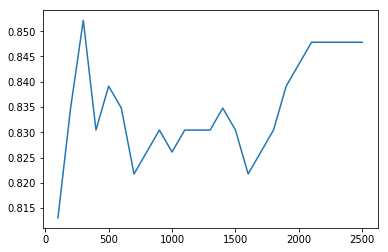

[0.8130434782608695, 0.8347826086956521, 0.8521739130434782, 0.8304347826086956, 0.8391304347826087, 0.8347826086956521, 0.8217391304347826, 0.8260869565217391, 0.8304347826086956, 0.8260869565217391, 0.8304347826086956, 0.8304347826086956, 0.8304347826086956, 0.8347826086956521, 0.8304347826086956, 0.8217391304347826, 0.8260869565217391, 0.8304347826086956, 0.8391304347826087, 0.8434782608695652, 0.8478260869565217, 0.8478260869565217, 0.8478260869565217, 0.8478260869565217, 0.8478260869565217]


In [19]:
k = range(100,2600,100)
k_score = []
for i in k:  
    tfidf_pp_vec = TfidfVectorizer(analyzer='word', max_features = i)  
    X_tfidf_pp_train = tfidf_pp_vec.fit_transform(X_train2)
    X_tfidf_pp_test = tfidf_pp_vec.transform(X_test2)
    mnb_tfidf_pp = MultinomialNB(0.9)  
    mnb_tfidf_pp.fit(X_tfidf_pp_train, y_train2)
    score = mnb_tfidf_pp.score(X_tfidf_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

### cancel stop words

In [20]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
#en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i]]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,323808103780990976,RT @VitoCaro7: Good luck to @kyle_piersma toda...,Not labeled,Not labeled,Not related,Not related or not informative,rt @vitocaro7 : good luck to @kyle_piersma tod...
1,323873597825355778,RT @DianneG: wow. RT @AntDeRosa Photo captures...,Outsiders,Other Useful Information,Related and informative,Related and informative,rt @dianneg : wow . rt @antderosa photo captur...
2,323874466063085568,Awful scenes at the #BostonMarathon. The photo...,Not applicable,Other Useful Information,Related - but not informative,Not related or not informative,awful scene at the #bostonmarathon . the photo...
3,323874558325161984,Holy shit RT @theoriginalwak: What the fuck ju...,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative,holy shit rt @theoriginalwak : what the fuck j...
4,323875384603058176,RT @russian_market: BOMB EXPLOSION IN BOSTON (...,Media,Other Useful Information,Related and informative,Related and informative,rt @russian_market : bomb elosion in boston ( ...


In [21]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
tfidf_pp_vec = TfidfVectorizer(analyzer='word')
X_tfidf_pp_train = tfidf_pp_vec.fit_transform(X_train2)  
X_tfidf_pp_test = tfidf_pp_vec.transform(X_test2)

In [22]:
mnb_tfidf_pp = MultinomialNB(0.3)  
mnb_tfidf_pp.fit(X_tfidf_pp_train, y_train2)

evaluate_cross_validation(mnb_tfidf_pp, X_tfidf_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_tfidf_pp.score(X_tfidf_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_tfidf_pp.score(X_tfidf_pp_test, y_test2))

[0.7826087  0.82608696 0.79710145 0.8115942  0.75362319 0.85507246
 0.7826087  0.76811594 0.86956522 0.8115942 ]
Mean score: 0.806 (+/-0.012)
Accuracy for training: 0.965217391304
Accuracy for testing: 0.865217391304


In [23]:
y_tfidf_pp_predict = mnb_tfidf_pp.predict(X_tfidf_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_tfidf_pp_predict, digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_tfidf_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.8506    0.9424    0.8942       139
       Related and informative     0.8947    0.7473    0.8144        91

                   avg / total     0.8681    0.8652    0.8626       230

Confusion Matrix:
[[131   8]
 [ 23  68]]


In [24]:
X_tfidf_pp_test.shape

(230, 2517)

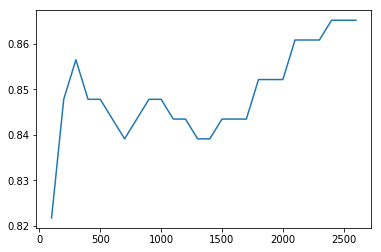

[0.8217391304347826, 0.8478260869565217, 0.8565217391304348, 0.8478260869565217, 0.8478260869565217, 0.8434782608695652, 0.8391304347826087, 0.8434782608695652, 0.8478260869565217, 0.8478260869565217, 0.8434782608695652, 0.8434782608695652, 0.8391304347826087, 0.8391304347826087, 0.8434782608695652, 0.8434782608695652, 0.8434782608695652, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8608695652173913, 0.8608695652173913, 0.8608695652173913, 0.8652173913043478, 0.8652173913043478, 0.8652173913043478]


In [25]:
k = range(100,2700,100)
k_score = []
for i in k:  
    tfidf_pp_vec = TfidfVectorizer(analyzer='word', max_features = i)  
    X_tfidf_pp_train = tfidf_pp_vec.fit_transform(X_train2)
    X_tfidf_pp_test = tfidf_pp_vec.transform(X_test2)
    mnb_tfidf_pp = MultinomialNB(0.3)  
    mnb_tfidf_pp.fit(X_tfidf_pp_train, y_train2)
    score = mnb_tfidf_pp.score(X_tfidf_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

### Combine plot

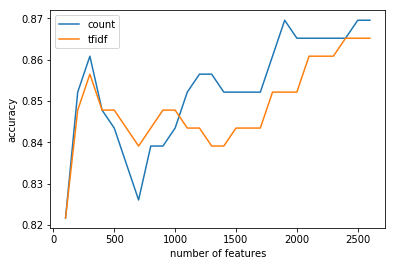

In [26]:
res_count = [0.8217391304347826, 0.8521739130434782, 0.8608695652173913, 0.8478260869565217, 0.8434782608695652, 0.8347826086956521, 0.8260869565217391, 0.8391304347826087, 0.8391304347826087, 0.8434782608695652, 0.8521739130434782, 0.8565217391304348, 0.8565217391304348, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8608695652173913, 0.8695652173913043, 0.8652173913043478, 0.8652173913043478, 0.8652173913043478, 0.8652173913043478, 0.8652173913043478, 0.8695652173913043, 0.8695652173913043]
res_tfidf = [0.8217391304347826, 0.8478260869565217, 0.8565217391304348, 0.8478260869565217, 0.8478260869565217, 0.8434782608695652, 0.8391304347826087, 0.8434782608695652, 0.8478260869565217, 0.8478260869565217, 0.8434782608695652, 0.8434782608695652, 0.8391304347826087, 0.8391304347826087, 0.8434782608695652, 0.8434782608695652, 0.8434782608695652, 0.8521739130434782, 0.8521739130434782, 0.8521739130434782, 0.8608695652173913, 0.8608695652173913, 0.8608695652173913, 0.8652173913043478, 0.8652173913043478, 0.8652173913043478]
l1, = plt.plot(k, res_count)
l2, = plt.plot(k, res_tfidf)
plt.legend(handles = [l1, l2,], labels = ['count', 'tfidf'], loc = 'best')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.show()